In [1]:
import numpy as np
import pandas as pd
import pydicom
from matplotlib import pyplot as plt
import os
from mask_functions import rle2mask, mask2rle
from google.cloud import storage

In [2]:
bucket = storage.Client().get_bucket("pneumothorax_chest_x-rays")

In [3]:
blobs = list(bucket.list_blobs(prefix='train/'))

In [4]:
df = pd.read_csv('gs://pneumothorax_chest_x-rays/train-rle.csv')
df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.151787518...,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.15178752...,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.151787518...,175349 7 1013 12 1009 17 1005 19 1003 20 1002...
3,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,407576 2 1021 7 1015 10 1013 12 1011 14 1008 ...
4,1.2.276.0.7230010.3.1.4.8323329.32579.15178751...,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1...


In [5]:
len(blobs)

10675

In [14]:
import torch
import torch.utils.data
import collections
from tqdm import tqdm_notebook
from PIL import Image

class TorchDataset(torch.utils.data.Dataset):
    def __init__(self, blobs, df):
        self.blobs = blobs

        self.df = df
        
        self.image_info = collections.defaultdict(dict)
###        
        i = 0
        for blob in tqdm_notebook(self.blobs):
            file_path = blob.name
            img_id = file_path.split('/')[-1][:-4]
            
            df_temp = self.df.loc[self.df.ImageId == img_id]
            rle_list = list()
            for x in range(len(df_temp)):
                rle = df_temp.iloc[x, 1].strip()
                rle_list.append(rle)
            
            for y in rle_list:
                if y != '-1':
                    dcm_path = './dataset/{}.dcm'.format(img_id)
                    png_path = './dataset_png/{}.png'.format(img_id)

                    # if the dcm is not downloaded, download it.
                    if not os.path.exists(dcm_path):
                        with open(dcm_path, 'wb') as file_obj:
                            blob.download_to_file(file_obj)  
                    # if the png is not created, create it.
                    if not os.path.exists(png_path):
                        with open(png_path, 'wb') as file_obj:
                            dcm_data = pydicom.dcmread(dcm_path)#, force=True)
                            img = dcm_data.pixel_array
                            img_mem = Image.fromarray(img)
                            img_mem.save(file_obj)

                    self.image_info[i]["image_id"] = img_id
                    self.image_info[i]["image_path"] = png_path
                    self.image_info[i]["annotations"] = rle_list
                    i += 1
                    break

        print(i)
###       
    def __getitem__(self, idx):
        # images
        img_path = self.image_info[idx]["image_path"]
        img = Image.open(img_path).convert("RGB")

        # masks
        rle_list = self.image_info[idx]["annotations"]
        mask = np.zeros((1024 ,1024))
        for i, rle in enumerate(rle_list):
            mask += rle2mask(rle_list[i], 1024, 1024).T
        mask = (mask > 127).astype(np.uint8) 
        
        ### the above part is identical as class TorchDataset in MaskRCNN(training notebook)
        mask = np.where(mask==0, 0, 255)
        tsr = torchvision.transforms.ToTensor()(img)
        return img, mask, tsr, self.image_info[idx]["image_id"]
    

    def __len__(self):
        return len(self.image_info)

In [15]:
dataset_test_entire = TorchDataset(blobs, df)


2379


In [16]:
len(dataset_test_entire)

2379

In [19]:
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset_test_entire)).tolist()

dataset_test = torch.utils.data.Subset(dataset_test_entire, indices[-50:])

In [20]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)

# load the trained parameter
model.load_state_dict(torch.load('./model/model_para.pt'))

# move model to the right device
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
    

In [22]:
# pick one image from the test set
img, mask, tsr, img_id = dataset_test[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([tsr.to(device)])

In [23]:
prediction

[{'boxes': tensor([[ 111.0120,  732.2556,  190.3830, 1002.4879],
          [ 190.0946,  223.2636,  477.2623,  526.4862],
          [ 288.0227,  222.5600,  487.7860,  377.2522],
          [ 117.7157,  717.0732,  295.4822, 1015.1249],
          [ 299.6837,  224.0411,  481.8001,  305.0521],
          [ 139.3788,  683.5671,  407.7328, 1016.3821],
          [ 114.3565,  219.6492,  460.8199, 1021.6840],
          [ 647.1865,  206.0482,  945.7739,  855.9852],
          [ 822.0402,  300.2668,  950.9944,  838.2783],
          [ 647.4220,  210.0570,  879.0869,  393.4100],
          [ 637.3751,  214.6201,  771.8344,  258.8106],
          [ 640.4020,  213.3731,  903.9554,  563.9504],
          [ 191.0685,  368.9768,  258.6919,  511.4310],
          [ 331.1994,  222.6424,  471.5747,  275.1474],
          [ 133.6578,  652.1477,  227.0530, 1015.6513],
          [ 647.0946,  218.8770,  753.3374,  245.7915],
          [ 637.1367,  213.9535,  803.4993,  287.9833],
          [ 190.2465,  290.2201,  309.7

In [24]:
scores = prediction[0]['scores']
scores_binary = (scores >= 0.3) #threshold

# no score/mask or all the scores < threshold
if len(scores) ==0 or scores_binary.all == 0:
    rle = '-1'

else:
    masks = prediction[0]['masks'].mul(255).byte().cpu().numpy()
    mask_pred = np.zeros_like(masks[0, 0]).astype(np.uint64) #change type to prevent overflow
    for i, binary in enumerate(scores_binary):
        if binary ==1:
            mask_pred += masks[i, 0]
    mask_pred = (mask_pred > 127).astype(np.uint8)
    mask_pred = np.where(mask_pred ==0, 0, 255)

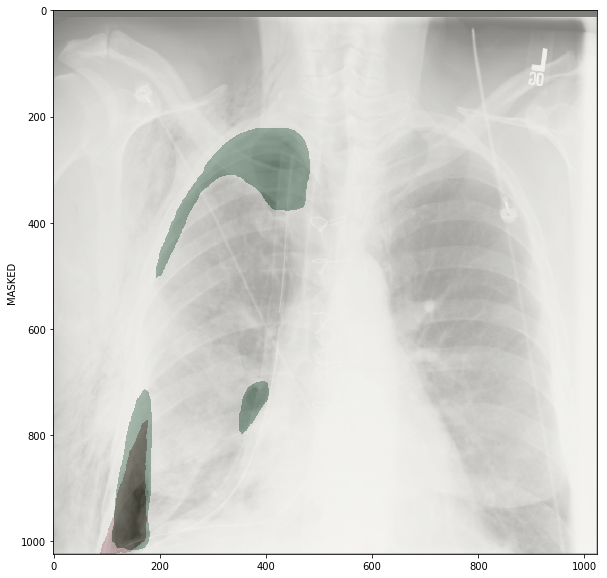

In [27]:
plt.figure(figsize=(10,10))
plt.ylabel('MASKED')

plt.imshow(img, cmap=plt.cm.bone)
plt.imshow(mask, alpha=0.3, cmap="Reds")

plt.imshow(mask_pred, alpha=0.3, cmap="Greens")